In [1]:
from uuid import uuid4
import numpy as np
import scipy.stats as st
from collections import defaultdict

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
def get_unet(n_channels=3, n_classes=1, batch_norm=False):
    # Fully convolutional, we don't specify the image size
    inputs = Input((None, None, n_channels))
    
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    if batch_norm:
        conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(pool1)
    if batch_norm:
        conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    if batch_norm:
        conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(pool2)
    if batch_norm:
        conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    if batch_norm:
        conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(pool3)
    if batch_norm:
        conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    if batch_norm:
        conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(pool4)
    if batch_norm:
        conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    if batch_norm:
        up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='elu', padding='same')(up6)
    if batch_norm:
        conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    if batch_norm:
        up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='elu', padding='same')(up7)
    if batch_norm:
        conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    if batch_norm:
        up8 = BatchNormalization()(up8)
    conv8 = Conv2D(64, (3, 3), activation='elu', padding='same')(up8)
    if batch_norm:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    if batch_norm:
        up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='elu', padding='same')(up9)
    if batch_norm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv9)
    if batch_norm:
        conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation=None)(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [5]:
class NonValidPatch(Exception):
    pass

In [6]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [7]:
class StreamStats(object):
    """ See https://www.johndcook.com/blog/standard_deviation/
    """
    def __init__(self):
        self.M = None
        self.S = None
        self.k = 0
        self.min = None
        self.max = None
        
    def update(self, x):
        self.k += 1
        if self.k == 1:
            self.M = x
            self.S = 0
            self.min = x
            self.max = x
        else:
            prevM = self.M
            prevS = self.S
            self.M = prevM + (x - prevM)/self.k
            self.S = prevS + (x - prevM) * (x - self.M)
            self.min = np.minimum(x, self.min)
            self.max = np.maximum(x, self.max)
            
    def mean(self):
        return self.M
        
    def variance(self):
        if self.k - 1 > 0:
            return self.S / (self.k - 1)
        else:
            return 0
    
    def std(self):
        return np.sqrt(self.variance())
    
    def minimum(self):
        return self.min
    
    def maximum(self):
        return self.max

In [8]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42,
                 debug_dir=None):
        
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        self.batch_size = batch_size
        
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        
        self.normalize = True
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
        
    def load_stats(self, uuid):
        self.x_scale = np.load(os.path.join(self.root_dir, "x_scale_{}.npy".format(uuid)))
        self.x_offset = np.load(os.path.join(self.root_dir, "x_offset_{}.npy".format(uuid)))
        self.y_scale = np.load(os.path.join(self.root_dir, "y_scale_{}.npy".format(uuid)))
        self.y_offset = np.load(os.path.join(self.root_dir, "y_offset_{}.npy".format(uuid)))
        
    def compute_stats(self, n_batches=100):
        self.normalize = False
        uuid = uuid4().hex
        input_stats = StreamStats()
        log_output_stats = StreamStats()
        scaled_output_stats = StreamStats()
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(bx.shape[0]):
                x = bx[b,...]
                x_mean_bgr = np.mean(np.mean(x, axis=0), axis=0)
                input_stats.update(x_mean_bgr)
            for b in range(by.shape[0]):
                y_log = by[b,...]
                for vy in y_log.ravel():
                    log_output_stats.update(vy)
                    
        self.x_scale = 1/(input_stats.std())
        self.x_offset = -input_stats.mean()/input_stats.std()
        np.save(os.path.join(self.root_dir, "x_scale_{}.npy".format(uuid)), self.x_scale)
        np.save(os.path.join(self.root_dir, "x_offset_{}.npy".format(uuid)), self.x_offset)
        
        ylog_min = log_output_stats.minimum()
        ylog_max = log_output_stats.maximum()        
        a1 = 1/(ylog_max - ylog_min )
        b1 = -a1 * ylog_min
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(by.shape[0]):
                y_log = by[b,...]
                y_scaled = a1 * y_log + b1
                for vy in y_scaled.ravel():
                    scaled_output_stats.update(vy)
        
        a2 = 1/scaled_output_stats.std()
        b2 = -scaled_output_stats.mean()/scaled_output_stats.std()
        self.y_scale = a1 * a2
        self.y_offset = a2 * b1 + b2
        np.save(os.path.join(self.root_dir, "y_scale_{}.npy".format(uuid)), self.y_scale)
        np.save(os.path.join(self.root_dir, "y_offset_{}.npy".format(uuid)), self.y_offset)
        self.normalize = True
        return uuid

    def normalize_input(self, x):
        if not self.normalize: return x
        
        return x * self.x_scale + self.x_offset
    
    def normalize_output(self, y):        
        ylog = np.log(y + 1e-9)
        if not self.normalize: return ylog
        
        return ylog * self.y_scale + self.y_offset
    
    def denormalize_output(self, y_normed):
        y_log = (y_normed - self.y_offset)/self.y_scale
        return np.exp(y_log) - 1e-9
    
    def denormalize_input(self, x_normed):
        return(x_normed - self.x_offset)/self.x_scale
    
    def random_flip(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        while 1:
            # Choose an output class randomly
            output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]

            try:
                # Sample a location, either for background or for a sealion.
                if output_class == self.n_sealion_types:
                    x, y = self.sample_bg(shape, image_id)
                else:
                    x, y = self.sample_dot(shape, dots[output_class], image_id)
            
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
            except NonValidPatch:
                continue
                
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                dmap = np.load(os.path.join(self.root_dir, "TrainEllipseDensity", uid + ".npz"))['dmap']
                dmap = np.sum(dmap, axis=-1, keepdims=True)
                dmap_patch = dmap[y:y+self.target_size[0], x:x+self.target_size[1], :]
                return self.random_flip(img_patch, dmap_patch)
        
    def sample_bg(self, shape, image_id):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, dots, image_id):
        half_size = 40
        
        randi = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 1), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i,:,:,:] = x
            batch_y[i,:,:,:] = y    

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        return self.normalize_input(batch_x), self.normalize_output(batch_y)

In [9]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42,
                 debug_dir=None):
        
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        self.batch_size = batch_size
        
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        
        self.normalize = True
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
        
    def load_stats(self, uuid):
        self.x_scale = np.load(os.path.join(self.root_dir, "x_scale_{}.npy".format(uuid)))
        self.x_offset = np.load(os.path.join(self.root_dir, "x_offset_{}.npy".format(uuid)))
        self.y_scale = np.load(os.path.join(self.root_dir, "y_scale_{}.npy".format(uuid)))
        self.y_offset = np.load(os.path.join(self.root_dir, "y_offset_{}.npy".format(uuid)))
        
    def compute_stats(self, n_batches=100):
        self.normalize = False
        uuid = uuid4().hex
        input_stats = StreamStats()
        log_output_stats = StreamStats()
        scaled_output_stats = StreamStats()
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(bx.shape[0]):
                x = bx[b,...]
                x_mean_bgr = np.mean(np.mean(x, axis=0), axis=0)
                input_stats.update(x_mean_bgr)
            for b in range(by.shape[0]):
                y_log = by[b,...]
                for vy in y_log.ravel():
                    log_output_stats.update(vy)
                    
        self.x_scale = 1/(input_stats.std())
        self.x_offset = -input_stats.mean()/input_stats.std()
        np.save(os.path.join(self.root_dir, "x_scale_{}.npy".format(uuid)), self.x_scale)
        np.save(os.path.join(self.root_dir, "x_offset_{}.npy".format(uuid)), self.x_offset)
        
        ylog_min = log_output_stats.minimum()
        ylog_max = log_output_stats.maximum()        
        a1 = 1/(ylog_max - ylog_min )
        b1 = -a1 * ylog_min
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(by.shape[0]):
                y_log = by[b,...]
                y_scaled = a1 * y_log + b1
                for vy in y_scaled.ravel():
                    scaled_output_stats.update(vy)
        
        a2 = 1/scaled_output_stats.std()
        b2 = -scaled_output_stats.mean()/scaled_output_stats.std()
        self.y_scale = a1 * a2
        self.y_offset = a2 * b1 + b2
        np.save(os.path.join(self.root_dir, "y_scale_{}.npy".format(uuid)), self.y_scale)
        np.save(os.path.join(self.root_dir, "y_offset_{}.npy".format(uuid)), self.y_offset)
        self.normalize = True
        return uuid

    def normalize_input(self, x):
        if not self.normalize: return x
        
        return x * self.x_scale + self.x_offset
    
    def normalize_output(self, y):        
        ylog = np.log(y + 1e-9)
        if not self.normalize: return ylog
        
        return ylog * self.y_scale + self.y_offset
    
    def denormalize_output(self, y_normed):
        y_log = (y_normed - self.y_offset)/self.y_scale
        return np.exp(y_log) - 1e-9
    
    def denormalize_input(self, x_normed):
        return(x_normed - self.x_offset)/self.x_scale
    
    def random_flip(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        while 1:
            # Choose an output class randomly
            output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]

            try:
                # Sample a location, either for background or for a sealion.
                if output_class == self.n_sealion_types:
                    x, y = self.sample_bg(shape, image_id)
                else:
                    x, y = self.sample_dot(shape, dots[output_class], image_id)
            
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
            except NonValidPatch:
                continue
                
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                dmap = np.load(os.path.join(self.root_dir, "TrainEllipseDensity", uid + ".npz"))['dmap']
                dmap = np.sum(dmap, axis=-1, keepdims=True)
                dmap_patch = dmap[y:y+self.target_size[0], x:x+self.target_size[1], :]
                return self.random_flip(img_patch, dmap_patch)
        
    def sample_bg(self, shape, image_id):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, dots, image_id):
        half_size = 40
        
        randi = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 1), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i,:,:,:] = x
            batch_y[i,:,:,:] = y    

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        return self.normalize_input(batch_x), self.normalize_output(batch_y)

In [10]:
mis_matched = set()
with open("../data/real_missmatched", "r") as f:
    f.readline()
    for line in f:
        mis_matched.add(int(line))

with open("../data/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(s[:-4]) for s in train_ids]

train_ids = list(set(train_ids).difference(mis_matched))

with open("../data/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(s[:-4]) for s in val_ids]
val_ids = list(set(val_ids).difference(mis_matched))

In [11]:
class_weights = [0.34,  0.42, 0.05, 0.09, 0.11, 0.01]

In [41]:
trainPatchesGenerator = PatchIterator("/home/ubuntu/sealion/data/", train_ids, class_weights, batch_size=16)

In [13]:
uuid = trainPatchesGenerator.compute_stats(100)

In [14]:
print(uuid)

667aaeeaa93b4167b66a2c7e818156ee


In [42]:
trainPatchesGenerator.load_stats(uuid)

In [43]:
valPatchesGenerator = PatchIterator("/home/ubuntu/sealion/data/", val_ids, class_weights, batch_size=16)
valPatchesGenerator.load_stats(uuid)

In [44]:
unet = get_unet(3, 1, batch_norm=False)
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=mean_squared_error)

In [45]:
for batch_x, batch_y in trainPatchesGenerator:
    break

In [46]:
batch_ypred = unet.predict(batch_x)

In [47]:
batch_x.shape

(16, 224, 224, 3)

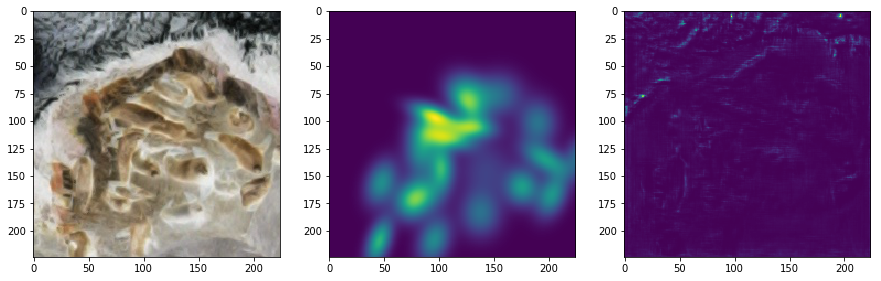

In [48]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0]))
plt.subplot(133)
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]))

In [49]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/reg_ellipses/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

In [50]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback
import tensorflow as tf

In [51]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [52]:
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/reg_ellipses/log_tb", batch_freq=10)

In [53]:
h = unet.fit_generator(trainPatchesGenerator, 400, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=8, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/20
400/400 [==============================] - 691s - loss: 0.6738 - val_loss: 0.5546
Epoch 2/20
400/400 [==============================] - 680s - loss: 0.4914 - val_loss: 0.5268
Epoch 3/20
400/400 [==============================] - 682s - loss: 0.4498 - val_loss: 0.4497
Epoch 4/20
400/400 [==============================] - 682s - loss: 0.4125 - val_loss: 0.4111
Epoch 5/20
400/400 [==============================] - 684s - loss: 0.3937 - val_loss: 0.4233
Epoch 6/20
400/400 [==============================] - 682s - loss: 0.3810 - val_loss: 0.4554
Epoch 7/20
400/400 [==============================] - 682s - loss: 0.3585 - val_loss: 0.3931
Epoch 8/20
400/400 [==============================] - 682s - loss: 0.3610 - val_loss: 0.3882
Epoch 9/20
400/400 [==============================] - 682s - loss: 0.3515 - val_loss: 0.3267
Epoch 10/20
400/400 [==============================] - 681s - loss: 0.3297 - val_loss: 0.3749
Epoch 11/20
400/400 [==============================] - 681s - loss: 0

In [55]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [56]:
batch_ypred = unet.predict(batch_x)

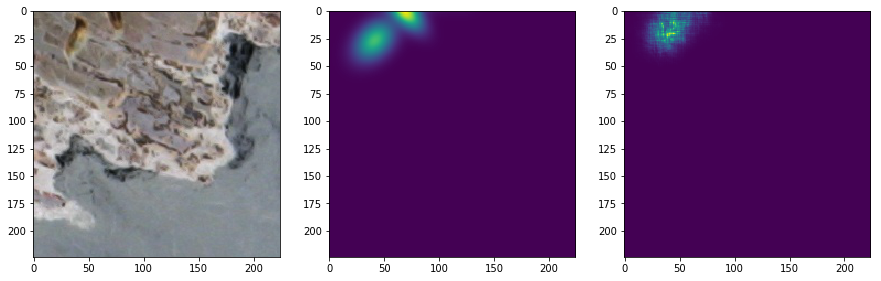

In [74]:
i = 10
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0]))
plt.subplot(133)
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]))

In [111]:
from keras.layers import GlobalAveragePooling2D

In [163]:
small_feature_map = unet.layers[14]
x = small_feature_map.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
counts = Dense(5, activation='linear')(x)

In [164]:
count_net = Model(inputs = [unet.input], outputs=[counts])

In [165]:
for layer in unet.layers:
    layer.Trainable = False

In [208]:
def cap_mean_squared_error(y_true, y_pred):
    loss = mean_squared_error(y_true, y_pred)
    return K.clip(loss, 0, 10)

In [209]:
sgd = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
count_net.compile(optimizer=sgd, loss=cap_mean_squared_error)

In [210]:
count_net.predict(batch_x).shape

(16, 5)

In [211]:
class CountIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42,
                 debug_dir=None):
        
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        self.batch_size = batch_size
        
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        
        self.normalize = True
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(CountIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
        
    def load_stats(self, uuid):
        self.x_scale = np.load(os.path.join(self.root_dir, "x_scale_{}.npy".format(uuid)))
        self.x_offset = np.load(os.path.join(self.root_dir, "x_offset_{}.npy".format(uuid)))
        self.y_scale = np.load(os.path.join(self.root_dir, "y_scale_{}.npy".format(uuid)))
        self.y_offset = np.load(os.path.join(self.root_dir, "y_offset_{}.npy".format(uuid)))

    def compute_stats(self, n_batches=100):
        self.normalize = False
        uuid = uuid4().hex
        input_stats = StreamStats()
        output_stats = StreamStats()

        for b in range(n_batches):
            bx, by = self.next()
            for b in range(bx.shape[0]):
                x = bx[b,...]
                x_mean_bgr = np.mean(np.mean(x, axis=0), axis=0)
                input_stats.update(x_mean_bgr)
            for b in range(by.shape[0]):
                y = by[b,...]
                output_stats.update(y)

        self.x_scale = 1/(input_stats.std())
        self.x_offset = -input_stats.mean()/input_stats.std()
        self.y_scale = 1/(output_stats.std())
        self.y_offset = -output_stats.mean()/output_stats.std()
        np.save(os.path.join(self.root_dir, "x_scale_{}.npy".format(uuid)), self.x_scale)
        np.save(os.path.join(self.root_dir, "x_offset_{}.npy".format(uuid)), self.x_offset)
        np.save(os.path.join(self.root_dir, "y_scale_{}.npy".format(uuid)), self.y_scale)
        np.save(os.path.join(self.root_dir, "y_offset_{}.npy".format(uuid)), self.y_offset)
        self.normalize = True
        return uuid
        
    def normalize_input(self, x):
        if not self.normalize: return x
        
        return x * self.x_scale + self.x_offset
    
    def denormalize_input(self, x_normed):
        return(x_normed - self.x_offset)/self.x_scale
    
    def normalize_output(self, y):
        if not self.normalize: return y
        
        return y * self.y_scale + self.y_offset
    
    def denormalize_output(self, y_normed):
        return(y_normed - self.y_offset)/self.y_scale
    
    def random_flip(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
    
    def sample(self, shape, dots, image_id):
        # if more than 30% of the patch is masked, reject it
        threshold_masked = 0.3 
        
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        while 1:
            # Choose an output class randomly
            output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]

            try:
                # Sample a location, either for background or for a sealion.
                if output_class == self.n_sealion_types:
                    x, y = self.sample_bg(shape, image_id)
                else:
                    x, y = self.sample_dot(shape, dots[output_class], image_id)
            
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
            except NonValidPatch:
                continue
                
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                dmap = np.load(os.path.join(self.root_dir, "TrainEllipseDensity", uid + ".npz"))['dmap']
                dmap_patch = dmap[y:y+self.target_size[0], x:x+self.target_size[1], ...]
                counts = np.sum(np.sum(dmap_patch, axis=0), axis=0)
                return self.random_flip(img_patch, img_patch)[0], counts
        
    def sample_bg(self, shape, image_id):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, dots, image_id):
        half_size = 40
        
        randi = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, 5), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i,:,:,:] = x
            batch_y[i,:] = y    

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        return self.normalize_input(batch_x), self.normalize_output(batch_y)

In [212]:
trainCountsGenerator = CountIterator("/home/ubuntu/sealion/data/", train_ids, class_weights, batch_size=16)

In [213]:
uuid_cnt = trainCountsGenerator.compute_stats(50)

In [214]:
print(uuid_cnt)

b8919a67e9484fba957f1dd94d8c5712


In [200]:
uuid_cnt = '433fd9000a6f4b92b8f8d5c80d723910'

In [215]:
trainCountsGenerator.load_stats(uuid_cnt)
valCountsGenerator = CountIterator("/home/ubuntu/sealion/data/", val_ids, class_weights, batch_size=16)
valCountsGenerator.load_stats(uuid_cnt)

In [216]:
for batch_x, batch_y in trainCountsGenerator:
    break

In [217]:
batch_y.shape

(16, 5)

[ 0.          0.          1.4472084   0.          1.00185013]


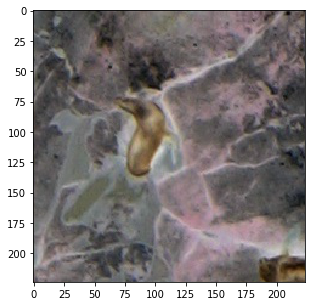

In [218]:
i = 0
plt.figure(figsize=(5, 5))
plt.imshow(valCountsGenerator.denormalize_input(batch_x[i,:,:, :]))
print(valCountsGenerator.denormalize_output(batch_y[i,:]))

In [219]:
tensorboard_cb_cnt = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/reg_ellipses/log_tb_counts", batch_freq=10)
cb_checkpoint_cnt = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/reg_ellipses/ckpt_count_net_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr_cnt = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

In [220]:
h = count_net.fit_generator(trainCountsGenerator, 400, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint_cnt, cb_reduce_lr_cnt, tensorboard_cb_cnt],
                       validation_data=valCountsGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=8, workers=4, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/20
400/400 [==============================] - 526s - loss: 0.9358 - val_loss: 0.8941
Epoch 2/20
399/400 [============================>.] - ETA: 1s - loss: 0.9449

KeyboardInterrupt: 

In [ ]:
def capped_count_rmse(y_true, y_pred, y_scale, y_offset, weight):
    y_true_log = (y_true - y_offset) / y_scale
    y_true_denormed = K.exp(y_true_log) - 1e-9
    y_pred_log = (y_pred - y_offset) / y_scale
    y_pred_denormed = K.exp(y_pred_log) - 1e-9
    
    count_true = K.sum(K.sum(K.sum(y_true_denormed, axis=-1), axis=-1), axis=-1, keepdims=True)
    count_pred = K.sum(K.sum(K.sum(y_pred_denormed, axis=-1), axis=-1), axis=-1, keepdims=True)
    
    return K.clip(K.sqrt(mean_squared_error(count_true, count_pred)) * weight, 0, 3.0)

Calibrate count loss

In [54]:
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [ ]:
count_rmse_w1 = wrapped_partial(capped_count_rmse, y_scale=trainPatchesGenerator.y_scale, y_offset=trainPatchesGenerator.y_offset, weight=1)

In [ ]:
def calibrate_loss(net, old_lovalPatchesGeneratorew_loss, val_generator, n_batchs=100):
    "enumerateFind the weight to apply on new_loss to have the same mean than old_loss.
    
    This function is useful when we alternate between losses.
    It ensure that the next round of training will use a loss with the same range as the previous one,
    so that we can use the same lr without diverging, or converging to slowly.
    """
    old_losses = []
    new_losses = []
    for b, (batch_x, batch_y) in enumerate(val_generator):
        if b == n_batchs:
            break
        
        batch_ypred = net.predict(batch_x)
        old_losses.append(np.mean(old_loss(batch_y, batch_ypred)))
        new_loss.append(np.mean(new_loss(batch_y, batch_ypred)))
        
    mean_old_loss = np.mean(old_losses)
    mean_new_loss = np.mean(new_loss)
    weight = mean_old_loss/mean_new_loss
    return weight

In [ ]:
weight_count_rmse = calibrate_loss(unet, mean_squared_error, count_rmse_w1, valPatchesGenerator, n_batchs=100)
weight_count_rmse

In [ ]:
count_rmse_calibrated = wrapped_partial(capped_count_rmse, y_scale=trainPatchesGenerator.y_scale, y_offset=trainPatchesGenerator.y_offset, weight=weight_count_rmse)

In [ ]:
init_lr = unet.optimizer.lr
current_lr = unet.optimizer.lr * (1. / (1. + unet.optimizer.lr.decay * unet.optimizer.lr.iterations))

In [ ]:
sgd = SGD(lr=current_lr, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=count_rmse_calibrated)